In [1]:
# Imoports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
# Connect SQLite database.
db_conn = sqlite3.connect("SuperstoreDB/superstore.db")

In [3]:
# Load all the data from the db into a pandas df.
df = pd.read_sql(
    """
    SELECT *
    FROM OrdersDetails
    JOIN Products
        ON Products.ProductID = OrdersDetails.ProductID
    JOIN Orders
        ON Orders.OrderID = OrdersDetails.OrderID
    JOIN Customers
        ON Customers.CustomerID = Orders.CustomerID
    JOIN Addresses
        ON Addresses.AddressID = Orders.AddressID
    """, db_conn)

In [4]:
# Since we have done 4 JOINs loading the data, we now have duplicated columns. Let's drop them.
# Drop columns with duplicated names.
df = df.loc[:, ~df.columns.duplicated()]

In [5]:
# Converting Sales and Profit from Cents to Dollars.
df['Sales'] = df['Sales'] / 100
df['Profit'] = df['Profit'] / 100

When working with sales data, a common thing to do is to understand the customers' buying patterns using 3 parameters: Monetary (amount of money spent), Frequency (how frequently the customer bought something) and Recency (how many days has passed from today to their last purchase).

These parameters are not given to us; we will have to calculate them.

In [6]:
# First, we will create a new DataFrame by grouping the customers based on their ID and summing the Sales column.
df_monetary = df.groupby('CustomerID', as_index=False)['Sales'].sum()
df_monetary.head()

,CustomerID,Sales
0,AA-10315,5563.54
1,AA-10375,1056.36
2,AA-10480,1790.51
3,AA-10645,5086.90
4,AB-10015,886.15


Do the same with Frequency (How many unique Order IDs are there per customer?) and the Recency (Calculate it from the last order date in the dataset) and then merge all the 3 DataFrames.

In [7]:
# Calculate Frequency (How many unique Order IDs are there per customer?)
df_frequency = df.groupby('CustomerID', as_index=False)['OrderID'].count()
df_frequency.head()

,CustomerID,OrderID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6


In [8]:
# Calculate Recency (today (2017-12-30) - the last order date in the dataset)
df['OrderDate'] = pd.to_datetime(df['OrderDate'])                               # Convert OrderDate to datetime values
df_recency = df.groupby('CustomerID', as_index=False)['OrderDate'].max()        # Find last order date for each customer
df_recency['Recency'] = pd.to_datetime('2017-12-30') - df_recency['OrderDate']  # Calculate Recency
df_recency['Recency'] = df_recency['Recency'].dt.days.astype(int)               # Covert from timedelta64 days to int
df_recency.drop(['OrderDate'], axis=1, inplace=True)                            # Remove unnecessary columns
df_recency.head()

,CustomerID,Recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


In [9]:
# Merge all the 3 DataFrames and give the columns better names.
rfm_df = pd.merge(pd.merge(df_monetary,df_frequency,on='CustomerID'),df_recency,on='CustomerID')
rfm_df.rename(columns={'Sales': 'Amount',
                       'OrderID': 'Frequency'},
                       inplace=True)
rfm_df

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.54,11,184
1,AA-10375,1056.36,15,19
2,AA-10480,1790.51,12,259
3,AA-10645,5086.90,18,55
4,AB-10015,886.15,6,415
...,...,...,...,...
788,XP-21865,2374.62,28,43
789,YC-21895,5454.34,8,4
790,YS-21880,6720.43,12,9
791,ZC-21910,8025.63,31,54


### Dealing with outliers
Because of its nature, the K-Means algorithm is susceptible to outliers. To check the consequences of having outliers when using a K-Means algorithm, read this article: [Effect of outliers on K-Means algorithm using Python](https://medium.com/analytics-vidhya/effect-of-outliers-on-k-means-algorithm-using-python-7ba85821ea23)


Visualize with a boxplot the 3 parameters and check if there are any outliers there.

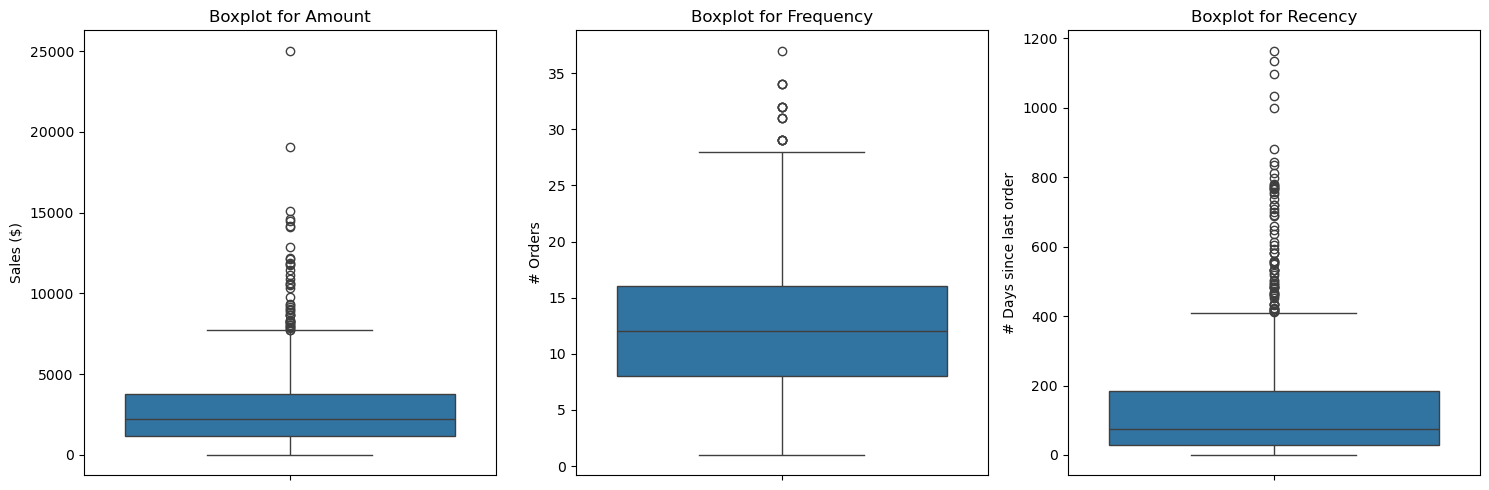

In [10]:
# Create a boxplot for each parameter
plt.figure(figsize=(15, 5))

# Boxplot for Amount
plt.subplot(1, 3, 1)
#plt.boxplot(rfm_df['Amount'])
sns.boxplot(y='Amount', data=rfm_df)
plt.title('Boxplot for Amount')
plt.ylabel('Sales ($)')

# Boxplot for Frequency
plt.subplot(1, 3, 2)
#plt.boxplot(rfm_df['Frequency'])
sns.boxplot(y='Frequency', data=rfm_df)
plt.title('Boxplot for Frequency')
plt.ylabel('# Orders')

# Boxplot for Recency
plt.subplot(1, 3, 3)
#plt.boxplot(rfm_df['Recency'])
sns.boxplot(y='Recency', data=rfm_df)
plt.title('Boxplot for Recency')
plt.ylabel('# Days since last order')

plt.tight_layout()
plt.show()


Remove each feature's (statistical) outliers using the Interquartile Range (IQR is the difference between the upper quartile and the lower quartile).

In [11]:
def claculate_iqr_bounds(df_column):
    # Calculate Q1, Q3, and IQR
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (lower_bound, upper_bound)

In [12]:
# Remove each feature's (statistical) outliers using the Interquartile Range.

# Save all the rows that classify as outliers.
outliers = {}                                                                                      # The outliers for each feature will be saved here
for feature in ['Amount', 'Frequency', 'Recency']:
    lower_bound, upper_bound = claculate_iqr_bounds(rfm_df[feature])                               # Calculate IQR bounds
    outliers[feature] = rfm_df[(rfm_df[feature] < lower_bound) | (rfm_df[feature] > upper_bound)]  # Save lines with outliers

# Merge all DataFrames with outliers into one
outliers_df = pd.concat(outliers.values())

# Filter out rows with CustomerIDs present in outliers_df
rfm_df = rfm_df[~rfm_df['CustomerID'].isin(outliers_df['CustomerID'])]

Make the boxplots again to see if the outliers removal was effective.

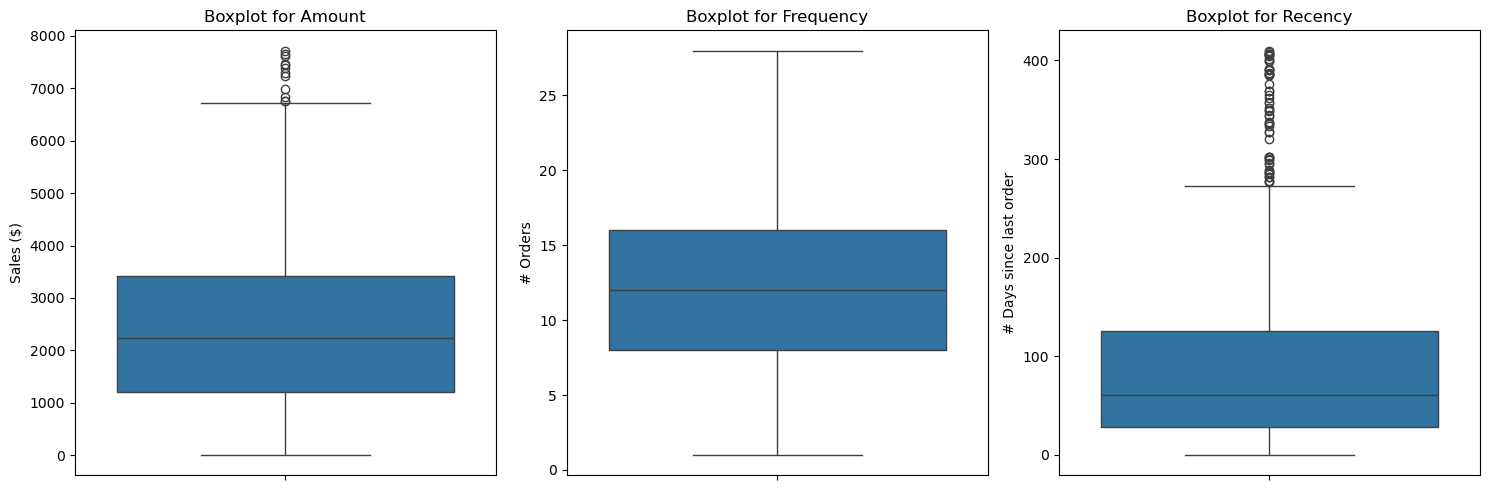

In [13]:
# Create a boxplot for each parameter
plt.figure(figsize=(15, 5))

# Boxplot for Amount
plt.subplot(1, 3, 1)
#plt.boxplot(rfm_df['Amount'])
sns.boxplot(y='Amount', data=rfm_df)
plt.title('Boxplot for Amount')
plt.ylabel('Sales ($)')

# Boxplot for Frequency
plt.subplot(1, 3, 2)
#plt.boxplot(rfm_df['Frequency'])
sns.boxplot(y='Frequency', data=rfm_df)
plt.title('Boxplot for Frequency')
plt.ylabel('# Orders')

# Boxplot for Recency
plt.subplot(1, 3, 3)
#plt.boxplot(rfm_df['Recency'])
sns.boxplot(y='Recency', data=rfm_df)
plt.title('Boxplot for Recency')
plt.ylabel('# Days since last order')

plt.tight_layout()
plt.show()


We can see that the scales all shrunk quite drastically after removing the outliers, which is what we wanted. Upper bounds went from ~25k to ~8k for Sales Amount, from ~35 to ~25 for Frequency and from ~1200 to ~400 for Recenc.

#### Feature scaling
Because of the nature of the algorithm, it is crucial to rescale the variables so that they have a comparable scale. There are two common ways of rescaling: Min-Max and Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [14]:
# Rescaling the attributes
rfm_df_to_scale = rfm_df[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df_to_scale)
display(rfm_df_scaled.shape)

# After fit_transform we need to change the type back from numpy.ndarray to pd.DataFrame
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

(669, 3)

,Amount,Frequency,Recency
0,1.801976,-0.263883,0.877375
1,-0.863258,0.467122,-0.812039
2,-0.429132,-0.081132,1.645291
3,1.520124,1.015375,-0.443440
4,-0.916282,-0.081132,-0.586784


### Building the model
K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms. The algorithm works as follows:
- First, we randomly initialize *k* points, called means. In this case, we will use 4 as a value.
- We categorize each item to its closest mean and update the mean's coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations, and, in the end, we have our clusters.

In [15]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, n_init='auto')
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4, n_init='auto')

### Finding the optimal number of clusters
As said before, we randomly decided that the number of clusters is 4. However, is it the optimal number?

There are two methods to determine the best k: the **Elbow method** and the **Silhouette analysis**.

**The Elbow Method**

According to the article [Elbow Method for optimal value of k in KMeans](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/), *"a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k."*

Although our first thought might be that increasing the number of parameters (k) will improve the fit of our model, we risk over fitting it. The Elbow Curve will help us identify when, if we were to add more clusters, it would only add so much more information to our model. The optimal k value will be where the average distance falls off suddenly. Which is when the curve starts to become parallel to the x-axis.



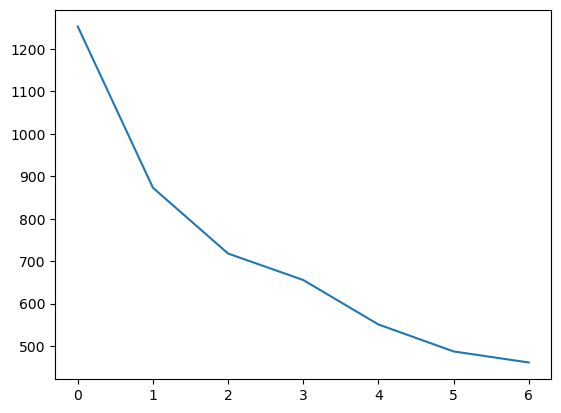

In [16]:
# Elbow-curve / SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In this case, we can assume that the optimal number of clusters is 3 (we start counting from 0, so 2 + 1), but it needs to be clarified as the Elbow is not very prominent.

**Silhouette Analysis**

Another way to determine the number of clusters is by using Silhouette Analysis. According to the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), it *"can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually."* Some people argue [that the Silhouette Analysis is better](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891) than the Elbow Method.



#### silhouette score = p - q / max(p,q)

- p is the mean distance to the points in the nearest cluster that the data point is not a part of.
- q is the mean intra-cluster distance to all the points in its own cluster.
- The value of the silhouette score range lies between -1 to 1.
- A score closer to 1 indicates that the data point is very similar to other data points in the cluster.
- A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [17]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3394854195212258
For n_clusters=3, the silhouette score is 0.3620567105324275
For n_clusters=4, the silhouette score is 0.3140579649091234
For n_clusters=5, the silhouette score is 0.3179031965664295
For n_clusters=6, the silhouette score is 0.3253163425473496
For n_clusters=7, the silhouette score is 0.2776985579858368
For n_clusters=8, the silhouette score is 0.2749548561190669


Based on the information given here and some research online, *k=3* seems to be the right choice.

In [18]:
# This is a fancier, more visual way to show the silhouette analysis and it does it's job, but isn't polished yet. 
"""
from matplotlib.colors import Normalize

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Define a colormap and normalization
cmap = plt.get_cmap('tab10')
norm = Normalize(vmin=0, vmax=max(range_n_clusters))

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_df_scaled, cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Use the same color for each cluster across plots
        color = cmap(norm(i))
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # 2nd Plot showing the actual clusters formed in 3D
    ax2 = fig.add_subplot(122, projection='3d')

    # Scatter plot for 3D data
    scatter = ax2.scatter(rfm_df['Amount'], rfm_df['Frequency'], rfm_df['Recency'], c=cluster_labels, cmap=cmap, norm=norm)

    # Add legend based on cluster IDs
    unique_clusters = np.unique(cluster_labels)
    cluster_labels = [f'Cluster {cluster_id}' for cluster_id in unique_clusters]
    ax2.legend(handles=scatter.legend_elements()[0], labels=cluster_labels, loc='upper right')

    # Add labels to the axes
    ax2.set_xlabel('Amount')
    ax2.set_ylabel('Frequency')
    ax2.set_zlabel('Recency')

    plt.show()
"""

'\nfrom matplotlib.colors import Normalize\n\n# Silhouette analysis\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8]\n\n# Define a colormap and normalization\ncmap = plt.get_cmap(\'tab10\')\nnorm = Normalize(vmin=0, vmax=max(range_n_clusters))\n\nfor num_clusters in range_n_clusters:\n\n    # intialise kmeans\n    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=\'auto\')\n    kmeans.fit(rfm_df_scaled)\n\n    cluster_labels = kmeans.labels_\n\n    # silhouette score\n    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)\n    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))\n\n    # Create a subplot with 1 row and 2 columns\n    fig, (ax1, ax2) = plt.subplots(1, 2)\n    fig.set_size_inches(15, 5)\n\n    # Compute the silhouette scores for each sample\n    sample_silhouette_values = silhouette_samples(rfm_df_scaled, cluster_labels)\n\n    y_lower = 10\n    for i in range(num_clusters):\n        # Aggregate the silhouette sc

### Train the model
Now let's train our final model with the appropriate value of *k*.

Then, assign the resulting labels to the Monetary, Frequency, and Recency DataFrame (before scaling).

In [19]:
# k-means with appropriate k-value
kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto', random_state=42)  # use random state this time, to make the results static, which helps describing them
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3, n_init='auto', random_state=42)

In [20]:
# Assign the label
rfm_df['ClusterId'] = kmeans.labels_
rfm_df.head()

/var/folders/n3/spvzfspj1gn51bldz75lhrt40000gn/T/ipykernel_3414/2271394110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['ClusterId'] = kmeans.labels_


,CustomerID,Amount,Frequency,Recency,ClusterId
0,AA-10315,5563.54,11,184,0
1,AA-10375,1056.36,15,19,2
2,AA-10480,1790.51,12,259,1
3,AA-10645,5086.90,18,55,0
7,AB-10150,966.69,12,41,2


Visualize the results:

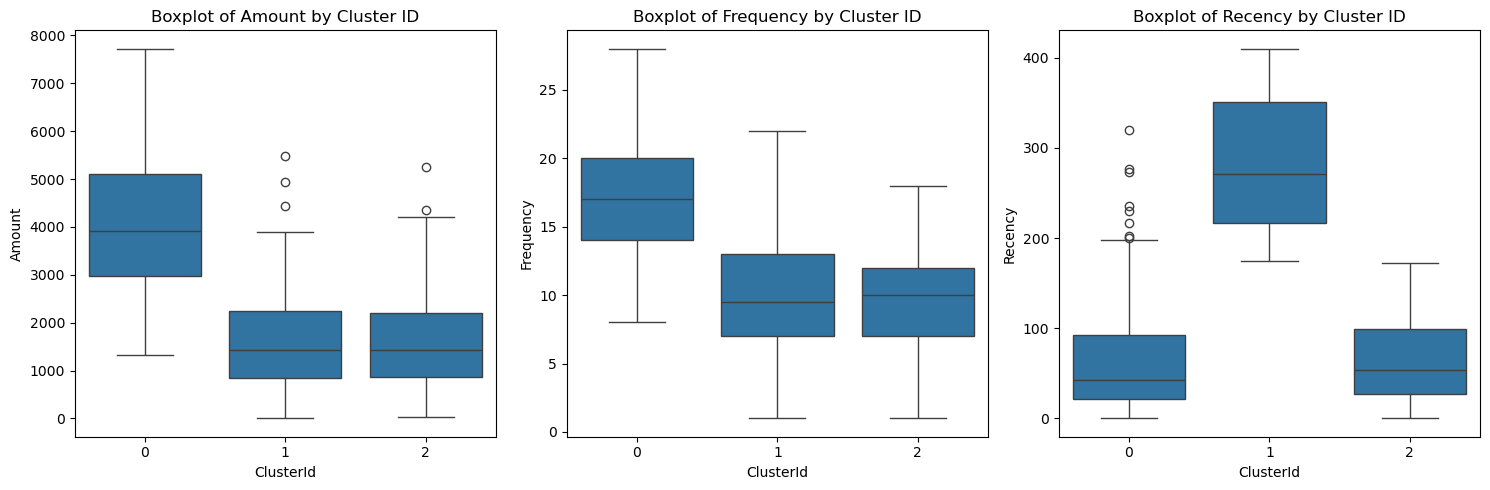

In [21]:
# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each feature and create a boxplot for each
for i, feature in enumerate(['Amount', 'Frequency', 'Recency']):
    sns.boxplot(x='ClusterId', y=feature, data=rfm_df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Cluster ID')

plt.tight_layout()
plt.show()

We can see that in fact the 3 customer groups we get after clustering are quite different from each other.
- cluster 0 - generates the highest sales numbers, places orders the most frequent and it's latest order has been quite recent. Those are our most loyal and  valuable customers.
- cluster 1 - generates lower sales numbers than cluster 0, but the same as cluster 2, has also the same order frequency as cluster 2, which is lower than cluster 0. The most interesting to us is the Recency for this cluster, which is quite bad. Those customers haven't placed an order in arround a years time. This might mean thei either shop once a year only or are lost customers.
- cluster 2 - as mentioned above has similar behaviour to cluster 1, with the difference that the customers made the last order quite recent. This might mean they are new customers (which would be surprising looking at the rate in which the company acquires customers) or more probably just customers spending a bit less than our best customers.

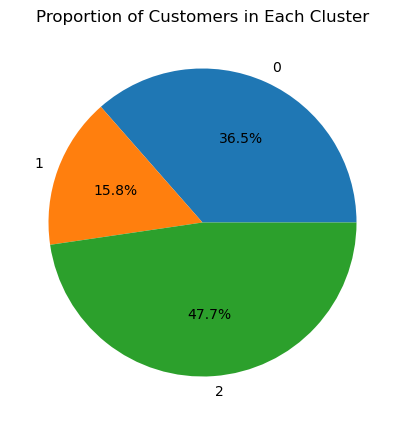

In [22]:
# Calculate the proportions of customers in each cluster
cluster_proportions = rfm_df['ClusterId'].value_counts(normalize=True).sort_index().round(4)

# Create a pie plot
plt.figure(figsize=(5, 5))  # Adjust the figure size here
plt.pie(cluster_proportions.values, labels=cluster_proportions.index, autopct='%1.1f%%')
plt.title('Proportion of Customers in Each Cluster')
plt.show()

- 15,8% of the customers are from the cluster that either shops once a year only or are lost customers
- 36,5% of the customers is in the group representing our most loyal and  valuable customers
- 47,7% of the customers are our less spending, but active 'normal' customers

In [23]:
# invoke ipympl to make embedded interactive graph.
# Installs best using conda install -c conda-forge ipympl
#%matplotlib ipympl

# comment this out if you run the script multiple times, because it will also affect other plots.

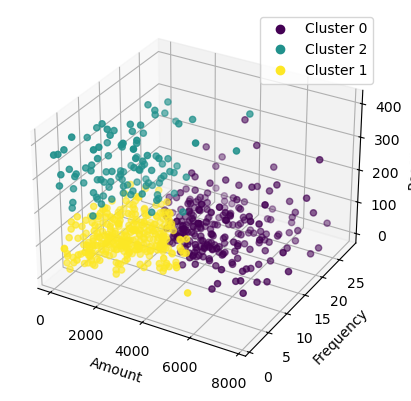

In [24]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cluster_id = rfm_df['ClusterId'].unique()

# Scatter plot for 3D data
scatter = ax.scatter(rfm_df['Amount'], rfm_df['Frequency'], rfm_df['Recency'], c=rfm_df['ClusterId'])

# Get unique cluster IDs and their corresponding labels
unique_clusters = rfm_df['ClusterId'].unique()
cluster_labels = [f'Cluster {cluster_id}' for cluster_id in unique_clusters]

# Add legend based on cluster IDs
ax.legend(handles=scatter.legend_elements()[0], labels=cluster_labels, loc='upper right')

# Add labels to the axes
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.show()

In [25]:
# the same 3D scatter plot as above, but generated with plotly
"""
import plotly.graph_objects as go

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rfm_df['Amount'],
    y=rfm_df['Frequency'],
    z=rfm_df['Recency'],
    mode='markers',
    marker=dict(
        size=5,
        color=rfm_df['ClusterId'],  # Color by ClusterId
        colorscale='Jet',  # Choose a colorscale
        opacity=0.8
    ),
    text=rfm_df['ClusterId'],  # Text when hovering over points
)])

# Add axis labels
fig.update_layout(scene=dict(
                    xaxis_title='Amount',
                    yaxis_title='Frequency',
                    zaxis_title='Recency'),
                  )

# Show the plot
fig.show()
"""

"\nimport plotly.graph_objects as go\n\n# Create the 3D scatter plot\nfig = go.Figure(data=[go.Scatter3d(\n    x=rfm_df['Amount'],\n    y=rfm_df['Frequency'],\n    z=rfm_df['Recency'],\n    mode='markers',\n    marker=dict(\n        size=5,\n        color=rfm_df['ClusterId'],  # Color by ClusterId\n        colorscale='Jet',  # Choose a colorscale\n        opacity=0.8\n    ),\n    text=rfm_df['ClusterId'],  # Text when hovering over points\n)])\n\n# Add axis labels\nfig.update_layout(scene=dict(\n                    xaxis_title='Amount',\n                    yaxis_title='Frequency',\n                    zaxis_title='Recency'),\n                  )\n\n# Show the plot\nfig.show()\n"

## Export the clusters

In [26]:
# export the clusters
rfm_df.to_csv('Exports/rfm_clusters.csv', index=False)

# Alternatevly the ClusterId could be saved in superstore.db as a column of Customers.
# For this we would have to set the default value of that column to a value representing outliers,
# because those wouldn't get a ClusterId otherwise.